## LOAD LIBRARIES

In [1]:
import pandas as pd
import json
import os
import networkx as nx
import tweepy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

base_path = "dataset/"

file_verified_users = "verified_users.txt"
file_verified_tweets = "verified_tweets.txt"

def graph_statistics(graph, plot=True):
    print("NODES:", len(graph.nodes))
    print("EDGES:", len(graph.edges))
    print("DENSITY: {:0.2}".format(nx.density(graph)))
    print("CONNECTED COMPONENTS:", nx.number_connected_components(graph))
    print("MAX CONNECTED COMPONENTS: ", max([len(x) for x in nx.connected_components(graph)]))
    print("CLUSTERING: {:0.2}".format(nx.average_clustering(graph)))
    if plot:
        plt.figure(figsize=(12,8))
        plt.title("CONNECTED COMPONENT DIMENSIONS")
        sns.histplot([len(x) for x in nx.connected_components(graph)], bins=100)
    
def centrality(graph, k=10):
    # degree
    degree = nx.degree_centrality(graph)
    degree = {k: v for k, v in sorted(degree.items(), key=lambda item: item[1], reverse=True)}
    # closeness
    clo = nx.closeness_centrality(graph)
    clo = {k: v for k, v in sorted(clo.items(), key=lambda item: item[1], reverse=True)}
    
    print("TOP USERS BY DEGREE")
    print(list(degree.keys())[:k])
    print("TOP USERS BY CLOSENESS")
    print(list(clo.keys())[:k])
    print("INTERSECTION")
    common = set(list(degree.keys())[:k]).intersection(list(clo.keys())[:k])
    print(common)
    
    fig, ax = plt.subplots(2,1,figsize=(12,8))
    ax[0].title.set_text("DEGREE CENTRALITY")
    sns.histplot(list(degree.values()), bins=50, ax=ax[0])
    ax[1].title.set_text("CLOSENESS CENTRALITY")
    sns.histplot(list(clo.values()), bins=50, ax=ax[1])
    return common

In [2]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 34.4 MB/s eta 0:00:00


DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.1/en_core_web_sm-3.4.1-py3-none-any.whl#egg=en_core_web_sm==3.4.1 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617

[notice] A new release of pip is available: 23.1.2 -> 23.2.1


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[notice] To update, run: python.exe -m pip install --upgrade pip


## LOAD TWEETS AND USERS DATAFRAME AND ADD NEW FEATURES

In [3]:
tweets = json.load(open(base_path + file_verified_tweets, "r"))
users  = open(base_path + file_verified_users, "r").read().split("\n")

In [4]:
df = pd.DataFrame.from_records(tweets)
df["created_at"] = pd.to_datetime(df["created_at"])
df["screen_name"] = df["user"].apply(lambda x: x["screen_name"])
df["followers"] = df["user"].apply(lambda x: x["followers_count"])
df["following"] = df["user"].apply(lambda x: x["friends_count"])
df["hashtags"] = df["entities"].apply(lambda x: [y["text"] for y in x["hashtags"]])
df["entity_text"] = df["full_text"].apply(lambda x: [y.text for y in nlp(x).ents])
df["entity_text"] = df["entity_text"].apply(lambda x: [y.replace("RT ", "") for y in x
                                                      if y not in ["#", "RT", "one", "today", "two",
                                                                  "1", "2", "first", "second", "this summer"]])

## EXPLORATORY DATA ANALYSIS

In [5]:
print("TWEETS:", len(df))
print("USERS:", len(users))
print("FIRST TWEET:", df["created_at"].min())
print("LAST TWEET:", df["created_at"].max())
print("# RETWEETED:", len(df.loc[~df["retweeted_status"].isna()]))
print("MAX FOLLOWERS:", df["followers"].max(), "(" , df.loc[df["followers"] == df["followers"].max()]["screen_name"].values[0], ")")
print("MIN FOLLOWERS:", df["followers"].min(), "(" , df.loc[df["followers"] == df["followers"].min()]["screen_name"].values[0], ")")
print("MAX FOLLOWING:", df["following"].max(), "(" , df.loc[df["following"] == df["following"].max()]["screen_name"].values[0], ")")
print("MIN FOLLOWING:", df["following"].min(), "(" , df.loc[df["following"] == df["following"].min()]["screen_name"].values[0], ")")

TWEETS: 17008
USERS: 8736
FIRST TWEET: 2020-10-19 15:40:44+00:00
LAST TWEET: 2021-04-21 21:59:06+00:00
# RETWEETED: 6210
MAX FOLLOWERS: 55017706 ( CNN )
MIN FOLLOWERS: 123 ( ricci_catalina )
MAX FOLLOWING: 595561 ( DanielNewman )
MIN FOLLOWING: 0 ( ZaidZamanHamid )


<AxesSubplot:title={'center':'# TWEETS BY AUTHOR'}>

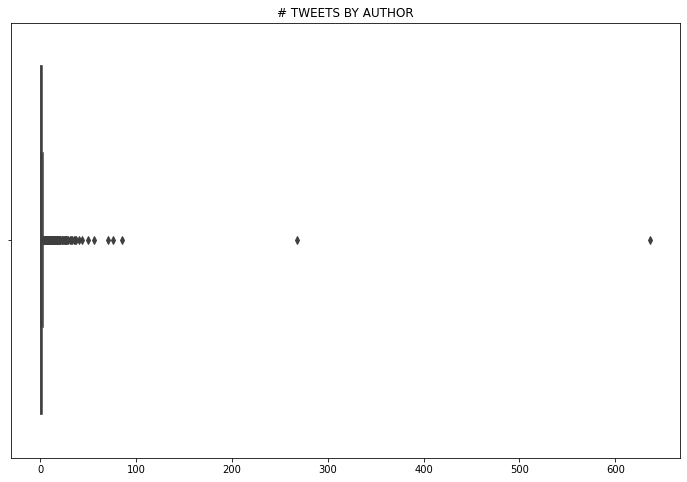

In [6]:
plt.figure(figsize=(12,8))
plt.title("# TWEETS BY AUTHOR")
sns.boxplot(x=df.groupby("screen_name")["screen_name"].count().values)

<AxesSubplot:>

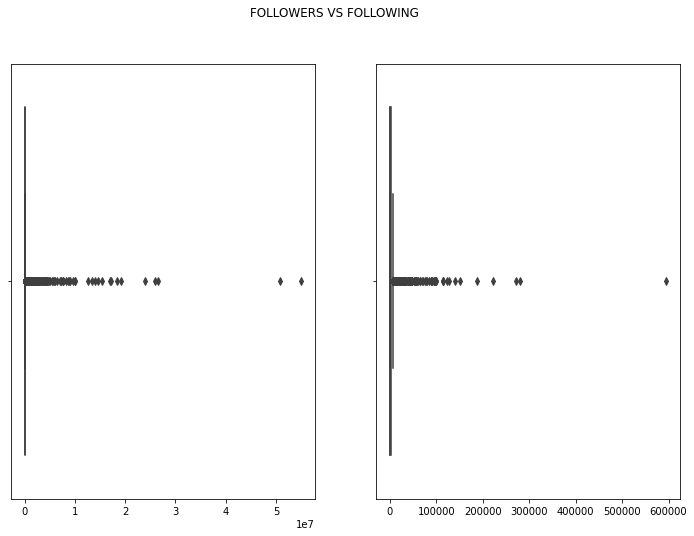

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle("FOLLOWERS VS FOLLOWING")
sns.boxplot(x=df.groupby("screen_name")["followers"].last().values, ax=ax[0])
sns.boxplot(x=df.groupby("screen_name")["following"].last().values, ax=ax[1])

<AxesSubplot:title={'center':'HASHTAGS'}>

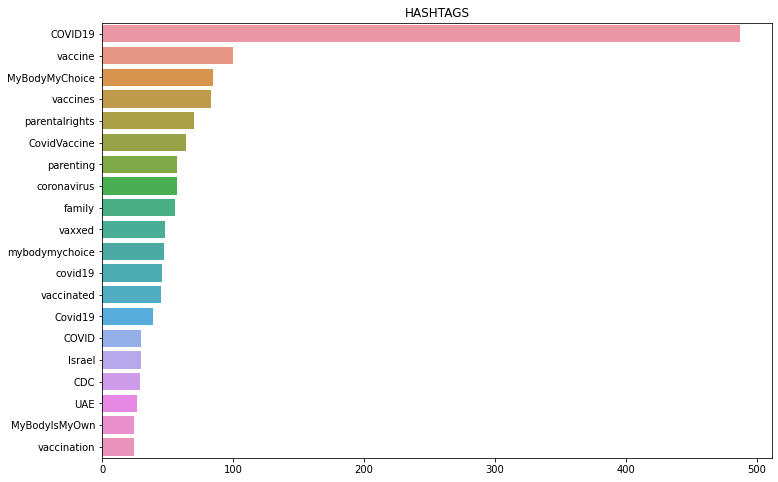

In [8]:
plt.figure(figsize=(12,8))
plt.title("HASHTAGS")
h = [x for y in df["hashtags"].to_list() for x in y]
h = pd.Series(h).value_counts()[:20]
sns.barplot(x=h.values, y=h.index, orient="h")

<AxesSubplot:title={'center':'ENTITY IN FULL_TEXT'}>

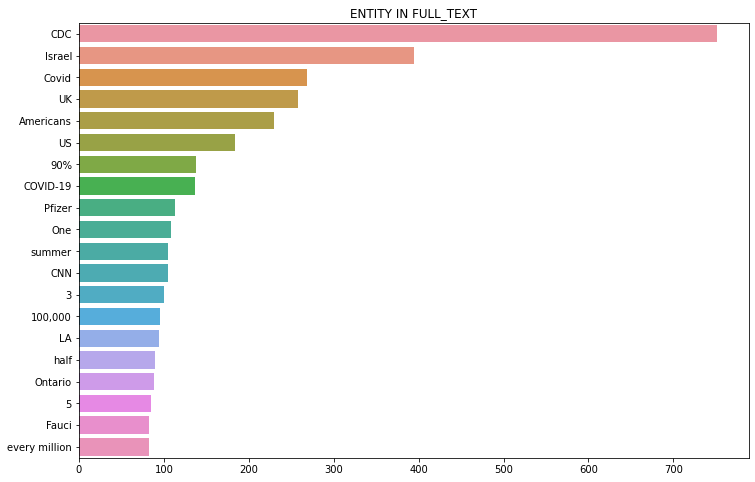

In [9]:
plt.figure(figsize=(12,8))
plt.title("ENTITY IN FULL_TEXT")
h = [x for y in df["entity_text"].to_list() for x in y]
h = pd.Series(h).value_counts()[:20]
sns.barplot(x=h.values, y=h.index, orient="h")

<AxesSubplot:title={'center':'ENTITY IN FULL_TEXT'}>

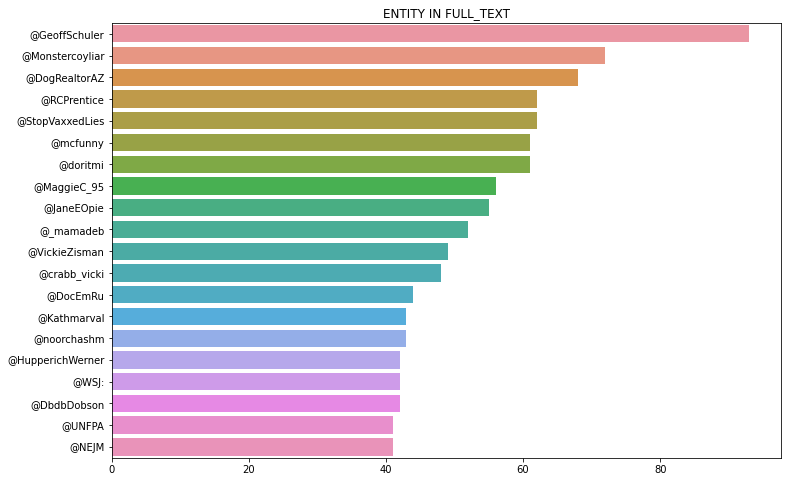

In [10]:
plt.figure(figsize=(12,8))
plt.title("ENTITY IN FULL_TEXT")
h = [x for y in df["entity_text"].to_list() for x in y if "@" in x]
new_h = []
for x in h:
    if " " in x:
        c = x.split(" ")
        for y in c:
            if "@" in y:
                new_h.append(y)
    else:
        new_h.append(x)

h = pd.Series(new_h).value_counts()[:20]
sns.barplot(x=h.values, y=h.index, orient="h")

## CREATE REPLY NETWORK

In [11]:
# create nodes
reply_graph = nx.Graph()

for u in users:
    reply_graph.add_node(u.split(",")[0])

In [12]:
# create edges
for t in tweets:
    if t["in_reply_to_screen_name"] in reply_graph.nodes:
        a, b = t["user"]["screen_name"], t["in_reply_to_screen_name"]
        if reply_graph.has_edge(a, b) or reply_graph.has_edge(b, a):
            reply_graph[a][b]["weight"] = reply_graph[a][b]["weight"] + 1
        else:
            reply_graph.add_edge(a, b, weight=1)

In [13]:
# save
nx.write_gexf(reply_graph, "network/reply_to.gexf")

## CREATE RETWEET NETWORK

In [14]:
# create nodes
retweet_graph = nx.Graph()

for u in users:
    retweet_graph.add_node(u.split(",")[0])

In [15]:
# create edges
retweet = df.loc[~df["retweeted_status"].isna()].copy(deep=True)
retweet["retweet_screen_name"] = retweet["retweeted_status"].apply(lambda x: x["user"]["screen_name"])

for _, t in retweet.iterrows():
    a, b = t["screen_name"], t["retweet_screen_name"]
    if a in retweet_graph.nodes and b in retweet_graph.nodes:
        if retweet_graph.has_edge(a, b) or retweet_graph.has_edge(b, a):
            retweet_graph[a][b]["weight"] = retweet_graph[a][b]["weight"] + 1
        else:
            retweet_graph.add_edge(a, b, weight=1)

In [16]:
# save
nx.write_gexf(retweet_graph, "network/retweet.gexf")

## CREATE NETWORK LIKE AND MENTION
Warning: network like is slightly different from the others, since the information about likes is obtained in a different way w.r.t. reply, mention and retweet

In [17]:
edges_list = pd.read_csv(base_path + "network_likes.csv", sep=";").apply(lambda x: 
                                                                         str(x[0]) + " " + str(x[1]) + " {'weight': " + str(x[2]) + "}", axis=1)
like_graph = nx.parse_edgelist(edges_list)


edges_list = pd.read_csv(base_path + "network_mentions.csv", sep=";").apply(lambda x: 
                                                                         str(x[0]) + " " + str(x[1]) + " {'weight': " + str(x[2]) + "}", axis=1)
mention_graph = nx.parse_edgelist(edges_list)

## REMOVE SELF-LOOP EDGES

In [18]:
retweet_graph.remove_edges_from(nx.selfloop_edges(retweet_graph))
reply_graph.remove_edges_from(nx.selfloop_edges(reply_graph))
like_graph.remove_edges_from(nx.selfloop_edges(like_graph))
mention_graph.remove_edges_from(nx.selfloop_edges(mention_graph))

## NETWORK DESCRIPTION

In [19]:
print("-" * 10, "REPLY", "-" * 10)
graph_statistics(reply_graph, plot=False)
print("-" * 10, "RETWEET", "-" * 10)
graph_statistics(retweet_graph, plot=False)
print("-" * 10, "MENTION", "-" * 10)
graph_statistics(mention_graph, plot=False)
print("-" * 10, "LIKE", "-" * 10)
graph_statistics(like_graph, plot=False)

---------- REPLY ----------
NODES: 8736
EDGES: 354
DENSITY: 9.3e-06
CONNECTED COMPONENTS: 8388
MAX CONNECTED COMPONENTS:  70
CLUSTERING: 0.00061
---------- RETWEET ----------
NODES: 8736
EDGES: 3429
DENSITY: 9e-05
CONNECTED COMPONENTS: 5690
MAX CONNECTED COMPONENTS:  2128
CLUSTERING: 0.0048
---------- MENTION ----------
NODES: 4426
EDGES: 4885
DENSITY: 0.0005
CONNECTED COMPONENTS: 590
MAX CONNECTED COMPONENTS:  3047
CLUSTERING: 0.067
---------- LIKE ----------
NODES: 835
EDGES: 762
DENSITY: 0.0022
CONNECTED COMPONENTS: 117
MAX CONNECTED COMPONENTS:  501
CLUSTERING: 0.0087


In [20]:
# get information about ego networks
def ego(graph, nodes):
    print("EGO ANALYSIS ON", nodes)
    density = 0
    clustering = 0
    for n in nodes:
        e = nx.ego_graph(graph, n)
        c = nx.average_clustering(e)
        d = nx.density(e)
        density += d
        clustering += c
        print(n, "nodes", len(e.nodes), "density", round(d, 3), "clustering", round(c, 3))
    return {"mean_density": round(density / len(nodes), 3), 
            "mean_clustering": round(clustering / len(nodes), 3)}

# get max component of graph
def get_max_component(graph):
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    return graph.subgraph(Gcc[0])

TOP USERS BY DEGREE
['doritmi', 'joshtpm', 'zeynep', 'dansaltzstein', 'ariehkovler', 'taraparkerpope', 'JoyAnnReid', 'EssexPR', 'byJenAMiller', 'JessicaValenti']
TOP USERS BY CLOSENESS
['zeynep', 'ariehkovler', 'CT_Bergstrom', 'joshtpm', 'apoorva_nyc', 'DrEricDing', 'AbraarKaran', 'NateSilver538', 'Bob_Wachter', 'SethAMandel']
INTERSECTION
{'zeynep', 'ariehkovler', 'joshtpm'}
EGO ANALYSIS ON []


ZeroDivisionError: division by zero

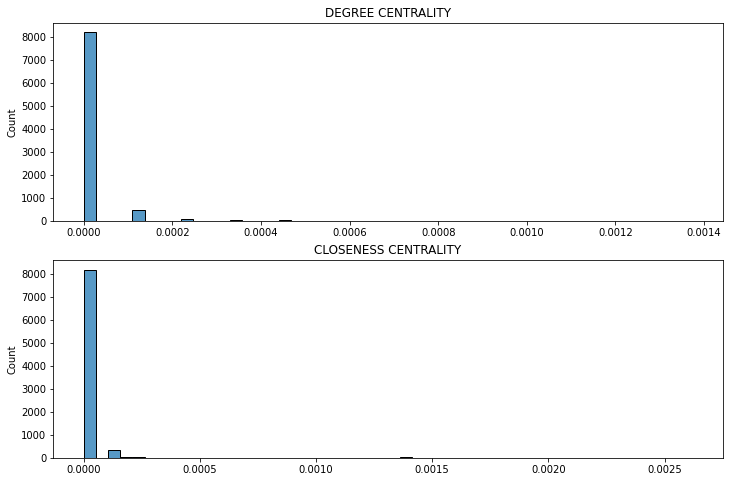

In [21]:
reply_common = centrality(reply_graph)
# insert users as second parameter of the "ego" function
print(ego(reply_graph, []))

TOP USERS BY DEGREE
['zeynep', 'jburnmurdoch', 'NateSilver538', 'PeterHotez', 'BisHilarious', 'ashishkjha', 'WSJ', 'ProfEmilyOster', 'kurtwearshats', 'NBCNews']
TOP USERS BY CLOSENESS
['zeynep', 'PeterHotez', 'doritmi', 'ashishkjha', 'ariehkovler', 'cindygallop', 'HotlineJosh', 'LizHIVHep', 'nicholas_bagley', 'NateSilver538']
INTERSECTION
{'zeynep', 'NateSilver538', 'PeterHotez', 'ashishkjha'}
EGO ANALYSIS ON []


ZeroDivisionError: division by zero

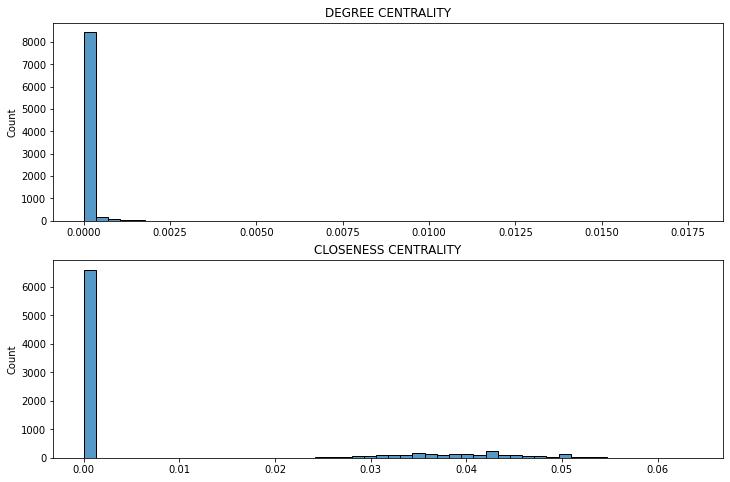

In [22]:
retweet_common = centrality(retweet_graph)
print(ego(retweet_graph, []))